In [2]:
import fsl
from fsl.data.image import Image
import skimage.io as io
import numpy as np
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
import nibabel as nib

def read_img(img_f):
    img = nib.load(img_f)
    img_data = img.get_fdata()
    shape = img_data.shape
    print("img shape is :" + str(shape))
    if len(shape) == 4:
        img_data = img_data[:, :, :, 0]
    
    return img_data

def show_3D_slice(img_data, slices_index=[0,0,0]):
    slice_0 = img_data[slices_index[0], :, :]
    slice_1 = img_data[:, slices_index[1], :]
    slice_2 = img_data[:, :, slices_index[2]]
    slices = [slice_0, slice_1, slice_2]
    fig, axes = plt.subplots(1, len(slices),figsize=((20,20)))
    
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="gray", origin="lower")    

# Preparation
## Get files
Get T1, dwi, fmap image

``` shell
#!bin/sh

ses='ses-1/brain'

# get T1 image that corrected by fsl_anat
for sub in ../anat/sub*; do
    sub_id=${sub:8:7}
    mkdir $sub_id 
    echo $sub_id
    cp $sub/T1_biascorr.nii.gz ${sub_id}/T1_biascorr.nii.gz
    cp $sub/T1_biascorr_brain.nii.gz ${sub_id}/T1_biascorr_brain.nii.gz
    cp $sub/T1_biascorr_brain_mask.nii.gz ${sub_id}/T1_biascorr_brain_mask.nii.gz
done

# get dwi data and corresponding fmap
for sub in ../sub*; do
    sub_id=${sub:3}
    echo $sub_id
    mkdir ${sub_id}/dwi
    cp $sub/${ses}/dwi/* ${sub_id}/dwi/
    cp $sub/${ses}/fmap/*dti* ./${sub_id}
done
```

## Prepare fmap
fsl_prepare_fieldmap bet

``` bash
#!bin/sh
# prepare fmap
for dir in sub-*; do
    sub=${dir:0:7} 
    cd $dir
    rm *.json
    fname=${sub}_ses-1_magnitude2_dti.nii.gz

    if [ -f $fname ] ; then 
        bet ${sub}_ses-1_magnitude2_dti.nii.gz ${sub}_magnitude_brain -f 0.4
        fsl_prepare_fieldmap SIEMENS ${sub}_ses-1_phase2_dti.nii.gz  ${sub}_magnitude_brain ${sub}_fmap_rads 2.46
    else
        bet ${sub}_ses-1_magnitude_dti.nii.gz ${sub}_magnitude_brain -f 0.4
        fsl_prepare_fieldmap SIEMENS ${sub}_ses-1_phase_dti.nii.gz  ${sub}_magnitude_brain ${sub}_fmap_rads 2.46
    fi
    cd ..
done
```

## Eddy current correction
According to a suggestion from fsl mail list, run eddy current correction before epi_reg     
https://www.jiscmail.ac.uk/cgi-bin/wa-jisc.exe?A2=ind1601&L=FSL&P=R75512

In [4]:
!fslinfo sub-c01/dwi/sub-c01_ses-1_dti.nii.gz

data_type	INT16
dim1		112
dim2		112
dim3		75
dim4		31
datatype	4
pixdim1		2.000000
pixdim2		2.000000
pixdim3		2.000000
pixdim4		11.100000
cal_max		0.000000
cal_min		0.000000
file_type	NIFTI-1+


``` shell
#!bin/sh
# using eddy_openmp to correct eddy current distortion
for sub in sub-*; do
    cd $sub
    
    # creat a mask
    fslmaths *b0* -Tmean b0_mean
    bet b0_mean b0_mean_brain -m -f 0.2
    
    # run eddy
    eddy_openmp   \
    --imain=./dwi/${sub}_ses-1_dti.nii.gz \
    --mask=b0_mean_brain_mask.nii.gz \
    --index=../eddy/index.txt \
    --acqp=../eddy/acqparams.txt \
    --bvecs=./dwi/${sub}_ses-1_dti.bvec \
    --bvals=./dwi/${sub}_ses-1_dti.bval \
    --out=../eddy/${sub}_dti_eddy_corr \
    cd ..
done

```

### Eddy QC

``` shell
#!bin/sh
# stored in TBSS/eddy
for f in *eddy_corr.nii.gz; do
    sub_id=${f:0:7}
    eddy_quad ${sub_id}_dti_eddy_corr -idx index.txt -par acqparams.txt -m ../${sub_id}/b0_mean_brain_mask.nii.gz -b ../${sub_id}/dwi/${sub_id}_ses-2_dti.bval
done

eddy_squad quad_list.txt
```

### Remark
sub-c16 : dti data only has 15 volumns

## Registration and EPI distortion correction
**SKIPED**   
result image can not be used

``` shell
#!bin/sh
# using fieldmaps to perform registration and EPI distortion-correction simultaneously.
for sub in sub-c0*; do
    cd $sub
    fname = ${sub}_ses-1_magnitude2_dti.nii.gz
    if [ -f fname ]; then
        epi_reg \
        --epi=../eddy/eddy_result/${sub}_dti_eddy_corr.nii.gz \
        --t1=T1_biascorr.nii.gz \
        --t1brain=T1_biascorr_brain.nii.gz \
        --fmap=${sub}_fmap_rads.nii.gz \
        --fmapmag=${sub}_ses-1_magnitude2_dti.nii.gz \
        --fmapmagbrain=${sub}_magnitude_brain.nii.gz \
        --echospacing=0.000345 \
        --pedir=y \
        --out=${sub}_dtireg & 
    else
        epi_reg \
        --epi=../eddy/eddy_result/${sub}_dti_eddy_corr.nii.gz \
        --t1=T1_biascorr.nii.gz \
        --t1brain=T1_biascorr_brain.nii.gz \
        --fmap=${sub}_fmap_rads.nii.gz \
        --fmapmag=${sub}_ses-1_magnitude_dti.nii.gz \
        --fmapmagbrain=${sub}_magnitude_brain.nii.gz \
        --echospacing=0.000345 \
        --pedir=y \
        --out=${sub}_dtireg &
    fi
    cd ..
done

```

## Remark
sub-p13 does not have dti data, it is missing   
sub-p30 does not have enough files to do fieldmap correction, use raw data here. File name is changed for consistency

# Modeling
## Run DTIFIT

``` shell
#!bin/sh
for sub in sub*; do
    cd $sub
    dtifit \
    --data=../eddy/${sub}_dti_eddy_corr.nii.gz \
    --mask=b0_mean_brain_mask.nii.gz \
    --bvecs=dwi/${sub}_ses-1_dti.bvec \
    --bvals=dwi/${sub}_ses-1_dti.bval \
    --out=${sub}_dtifit &
    cd ..
done
```

## Run TBSS

``` shell
#!bin/sh
# collect FA image
mkdir tbss
for sub in sub*; do
    cp $sub/${sub}_dtifit_FA.nii.gz tbss/${sub}_dtifit_FA.nii.gz
done 

# Run TBSS
cd tbss
tbss_1_preproc *.nii.gz
tbss_2_reg -T
tbss_3_postreg -S
fsleyes -std1mm stats/mean_FA -cm red-yellow -dr 0.2 0.6 &
tbss_4_prestats 0.3
```

##  Run Randomise

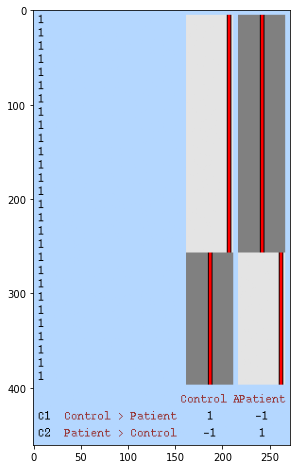

In [5]:
plt.figure(figsize=(6, 8))
im = plt.imread('./tbss/stats/design.png')
plt.imshow(im)

``` shell
randomise -i all_FA_skeletonised -o tbss \
  -m mean_FA_skeleton_mask -d design.mat -t design.con --T2
```

# Result
**18 Control, 10 Patients**  
sub-p13 dti image is missing
## FA image inspection

img shape is :(112, 112, 75)


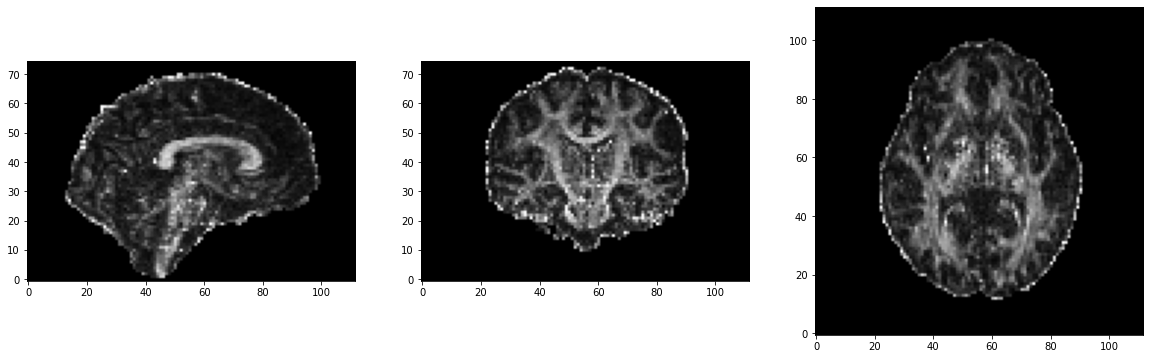

In [6]:
# FA image
epi_img = read_img('sub-c01/sub-c01_dtifit_FA.nii.gz')
show_3D_slice(epi_img, [55,55,35])

## TFCE Corrected result

In [1]:
! fsleyes -std tbss/stats/mean_FA_skeleton -cm green  \
tbss/stats/tbss_tfce_corrp_tstat1 -cm red-yellow -dr 0.949 1

In [8]:
# show fattened result
#!tbss_fill tbss_tfce_corrp_tstat1 0.95 mean_FA tbss_tfce_corrp_tstat1_filled

# Comparasion
## Patient & Control

``` shell
#!bin/sh
mkdir fa_values
for mask in masks/*.nii.gz; do
fslmeants -i all_FA_skeletonised -m ${mask} -o fa_values/${mask:6}_result.txt
done
```

In [9]:
import sqlite3
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
from pingouin import multivariate_normality # for pearson correlation
import rpy2.robjects as robjects # use basic R function

In [10]:
robjects.r(
'''
perm_ind_t <- function(group1_name,group2_name,stop_num, nreps=5000, seed=1086){
test_name <- substr(group1_name,4,as.numeric(stop_num))
g1 <- as.vector(read.csv(paste('./cache/',group1_name, sep=""))[,1])
g2 <- as.vector(read.csv(paste('./cache/',group2_name, sep=""))[,1])
n1 <- length(g1)
n2 <- length(g2)
N <- n1 + n2

meanNW <- mean(g1) 
meanW <- mean(g2) 
diffObt <- (meanW - meanNW)

ttest <- t.test(g2, g1)
tObt <-  ttest$statistic

Combined <- c(g1, g2)     # Combining the samples
meanDiff <- numeric(nreps)   #Setting up arrays to hold the results
t <- numeric(nreps)
set.seed(1086)        
    
for ( i in 1:nreps) {
      data <- sample(Combined, N,  replace = FALSE)
      grp1 <- data[1:n1]
      grp2 <- na.omit(data[n1+1: N])
      meanDiff[i] <- mean(grp1) - mean(grp2)
      test <- t.test(grp1, grp2)
      t[i] <- test$statistic
      }


absMeanDiff <- abs(meanDiff)
absDiffObt = abs(diffObt)
abst <- abs(t)
abstObt <- abs(tObt)
p <- length(abs(absMeanDiff[absMeanDiff >= absDiffObt]))/nreps

return(p)  
}

''')

# A test on a correlation coefficient.
robjects.r(
'''
perm_corr <- function(group1_name, group2_name, stop_num, nreps=5000, seed=1086){
test_name <- substr(group1_name,5,as.numeric(stop_num))
group1 <- as.vector(read.csv(paste('./cache/',group1_name, sep=""))[,1])
group2 <- as.vector(read.csv(paste('./cache/',group2_name, sep=""))[,1])
r.obt <- cor(group1, group2)
r.random <- numeric(nreps)
for (i in 1:nreps) {
Y <- group1
X <- sample(group2, length(group2), replace = FALSE)
r.random[i] <- cor(X,Y)
   }
prob <- length(r.random[r.random >= r.obt])/nreps
cat("Probability randomized r >= r.obt",prob)
hist(r.random, breaks = 50, main =  expression(paste("Distribution around ",rho, "= 0")), xlab = "r from randomized samples")
r.obt <- round(r.obt, digits = 4)
legend(.40, 200, r.obt, bty = "n")
arrows(.5,150,.53, 10)

return(prob) 
}
''')


R object with classes: ('function',) mapped to:

In [12]:
db_directory = r'../../database/SCI_pt.db'
db = sqlite3.connect(db_directory,timeout=30)
dbcr = db.cursor()

In [13]:
# get arrtributes of table
def get_columns(table_name):
    dbcr.execute("SELECT * FROM {}".format(table_name))
    col_list = [tuple[0] for tuple in dbcr.description]
    return col_list

sql = "select * from tbss "
dbcr.execute(sql)
tbss_data = pd.DataFrame(map(list,dbcr.fetchall()),columns=get_columns('tbss')).set_index(['subjectID'])
%store tbss_data
tbss_data

Stored 'tbss_data' (DataFrame)


,corticospinal_l,external_capsule_l,retrolenticular_internal_capsule_l,retrolenticular_internal_capsule_r,sma_r,slf_l,slf_r,slf_temporal_l,slf_temporal_r,corticospinal_r,callosalbody,forcepts_minor,timepoint
subjectID,,,,,,,,,,,,,
C_001,0.120316,0.140761,0.214362,0.207760,0.134710,0.064718,0.137580,0.088980,0.096744,0.121356,0.100065,0.068604,0
C_002,0.123208,0.145213,0.219201,0.203769,0.145540,0.068454,0.140301,0.093371,0.104752,0.126043,0.102097,0.070669,0
C_003,0.115537,0.135532,0.205674,0.198607,0.134157,0.062933,0.123572,0.085843,0.091743,0.117743,0.094477,0.067546,0
C_004,0.120741,0.142543,0.219663,0.202728,0.136384,0.066506,0.135291,0.090320,0.098484,0.123611,0.097706,0.067584,0
C_005,0.116349,0.140951,0.197761,0.188610,0.130217,0.062598,0.122654,0.085463,0.090409,0.118574,0.095536,0.068243,0
C_006,0.121315,0.136572,0.207422,0.203620,0.137661,0.064338,0.131256,0.087107,0.096079,0.122356,0.097219,0.068089,0
C_007,0.130330,0.145799,0.232956,0.224641,0.144422,0.071390,0.150884,0.097333,0.109524,0.130517,0.104040,0.072076,0
C_009,0.127811,0.155111,0.231195,0.221094,0.152221,0.069603,0.144600,0.094611,0.105851,0.131586,0.103673,0.073051,0
C_010,0.122119,0.134034,0.216962,0.196816,0.147714,0.066394,0.136815,0.090445,0.099717,0.126292,0.097613,0.068860,0


In [14]:
pd.set_option('max_columns',1000)
pd.set_option('max_row',300)
tbss_data.groupby('timepoint').mean().T

timepoint,0,1,2
corticospinal_l,0.123134,0.119792,0.122874
external_capsule_l,0.142659,0.136539,0.139540
retrolenticular_internal_capsule_l,0.217580,0.207104,0.212609
retrolenticular_internal_capsule_r,0.209498,0.198639,0.203099
sma_r,0.142115,0.135653,0.129080
slf_l,0.067000,0.064708,0.064450
slf_r,0.139188,0.132219,0.130699
slf_temporal_l,0.091304,0.087894,0.090665
slf_temporal_r,0.101027,0.096249,0.098501
corticospinal_r,0.124888,0.120790,0.117597


In [15]:
control_tbss = tbss_data[tbss_data['timepoint'] == 0].drop(['timepoint'], axis = 1)
patient_tbss = tbss_data[tbss_data['timepoint'] == 1].drop(['timepoint'], axis = 1)
patient_tbss_2 = tbss_data[tbss_data['timepoint']==2].drop(['timepoint'], axis = 1)
%store patient_tbss patient_tbss_2
control_tbss

Stored 'patient_tbss' (DataFrame)
Stored 'patient_tbss_2' (DataFrame)


,corticospinal_l,external_capsule_l,retrolenticular_internal_capsule_l,retrolenticular_internal_capsule_r,sma_r,slf_l,slf_r,slf_temporal_l,slf_temporal_r,corticospinal_r,callosalbody,forcepts_minor
subjectID,,,,,,,,,,,,
C_001,0.120316,0.140761,0.214362,0.207760,0.134710,0.064718,0.137580,0.088980,0.096744,0.121356,0.100065,0.068604
C_002,0.123208,0.145213,0.219201,0.203769,0.145540,0.068454,0.140301,0.093371,0.104752,0.126043,0.102097,0.070669
C_003,0.115537,0.135532,0.205674,0.198607,0.134157,0.062933,0.123572,0.085843,0.091743,0.117743,0.094477,0.067546
C_004,0.120741,0.142543,0.219663,0.202728,0.136384,0.066506,0.135291,0.090320,0.098484,0.123611,0.097706,0.067584
C_005,0.116349,0.140951,0.197761,0.188610,0.130217,0.062598,0.122654,0.085463,0.090409,0.118574,0.095536,0.068243
C_006,0.121315,0.136572,0.207422,0.203620,0.137661,0.064338,0.131256,0.087107,0.096079,0.122356,0.097219,0.068089
C_007,0.130330,0.145799,0.232956,0.224641,0.144422,0.071390,0.150884,0.097333,0.109524,0.130517,0.104040,0.072076
C_009,0.127811,0.155111,0.231195,0.221094,0.152221,0.069603,0.144600,0.094611,0.105851,0.131586,0.103673,0.073051
C_010,0.122119,0.134034,0.216962,0.196816,0.147714,0.066394,0.136815,0.090445,0.099717,0.126292,0.097613,0.068860


In [ ]:
%store -r Scale_Filtered
%who

In [15]:
scale_pt = Scale_Filtered[Scale_Filtered['timepoint'].isin([1])]
corr = patient_tbss.join(scale_pt)
corr

,corticospinal_l,external_capsule_l,retrolenticular_internal_capsule_l,retrolenticular_internal_capsule_r,sma_r,slf_l,slf_r,slf_temporal_l,slf_temporal_r,corticospinal_r,callosalbody,forcepts_minor,timepoint,SFMPQ,PDQ,PSQ,BDI,TAI,PSQI,FPQ_Severe,FPQ_Mild,FPQ_Medical,FPQ_Total,PASS,PCS_1,PCS_2,PCS_3,PCS_Total,PVAQ,LOT_R,NEO_1,NEO_2,NEO_3,NEO_4,NEO_5,SAI,VAS,HAMA,HAMD
subjectID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
P_014,0.112235,0.134705,0.191742,0.172373,0.123061,0.057314,0.108541,0.077678,0.082501,0.108904,0.086477,0.059366,1.0,85.0,15.0,92.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.0,80.0,9.0,9.0
P_015,0.112753,0.123661,0.190483,0.183301,0.135623,0.060838,0.126343,0.082456,0.093229,0.115136,0.090658,0.063979,1.0,78.0,13.0,53.0,7.0,34.0,6.0,39.0,27.0,28.0,94.0,27.0,6.0,2.0,2.0,10.0,40.0,19.0,28.0,30.0,36.0,42.0,46.0,NaN,85.0,4.0,2.0
P_016,0.121877,0.141839,0.208205,0.198861,0.137530,0.066005,0.135103,0.089786,0.097492,0.124456,0.097287,0.068188,1.0,94.0,22.0,129.0,3.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,6.0,3.0,1.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.0,80.0,3.0,4.0
P_018,0.117756,0.132008,0.200684,0.204269,0.126740,0.062388,0.133064,0.085743,0.096326,0.117760,0.091145,0.061372,1.0,36.0,10.0,24.0,3.0,31.0,7.0,13.0,10.0,11.0,34.0,5.0,1.0,0.0,1.0,2.0,26.0,22.0,16.0,51.0,37.0,58.0,54.0,24.0,10.0,1.0,0.0
P_019,0.117682,0.142149,0.197181,0.187081,0.140360,0.063786,0.133117,0.085896,0.095207,0.120804,0.097056,0.069097,1.0,42.0,21.0,58.0,4.0,35.0,7.0,26.0,15.0,22.0,63.0,47.0,6.0,6.0,10.0,22.0,48.0,22.0,21.0,43.0,39.0,46.0,57.0,32.0,50.0,0.0,0.0
P_021,0.120788,0.128587,0.205278,0.203644,0.139141,0.065934,0.134068,0.089204,0.096954,0.122001,0.093246,0.063627,1.0,89.0,11.0,110.0,15.0,NaN,3.0,43.0,25.0,23.0,91.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.0,75.0,5.0,5.0
P_022,0.123727,0.142677,0.215738,0.206830,0.140718,0.068690,0.139320,0.093463,0.102368,0.124289,0.101822,0.072667,1.0,107.0,36.0,108.0,7.0,39.0,4.0,43.0,32.0,41.0,116.0,45.0,7.0,2.0,13.0,22.0,32.0,22.0,25.0,41.0,29.0,45.0,53.0,37.0,80.0,6.0,2.0
P_023,0.118353,0.131597,0.217156,0.193639,0.127529,0.063727,0.126831,0.085176,0.094193,0.120271,0.095612,0.064999,1.0,60.0,21.0,82.0,5.0,29.0,3.0,42.0,18.0,22.0,82.0,14.0,5.0,1.0,3.0,9.0,34.0,22.0,24.0,40.0,36.0,42.0,51.0,43.0,40.0,0.0,0.0
P_024,0.128892,0.149049,0.226077,0.224986,0.141710,0.069529,0.143346,0.095045,0.103501,0.129055,0.103047,0.070069,1.0,56.0,14.0,37.0,3.0,30.0,3.0,19.0,15.0,18.0,52.0,10.0,8.0,1.0,3.0,12.0,26.0,23.0,16.0,52.0,19.0,54.0,59.0,20.0,60.0,0.0,0.0


## Correlation (dti & behaviour)

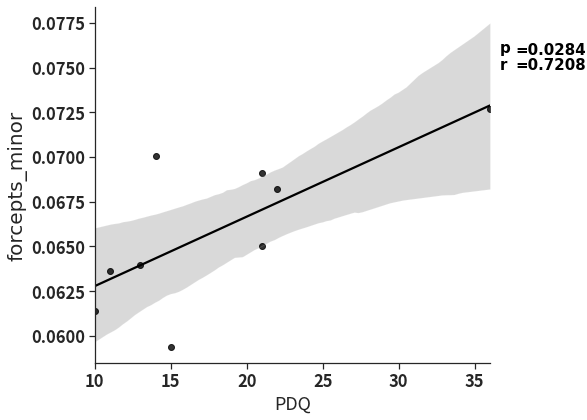

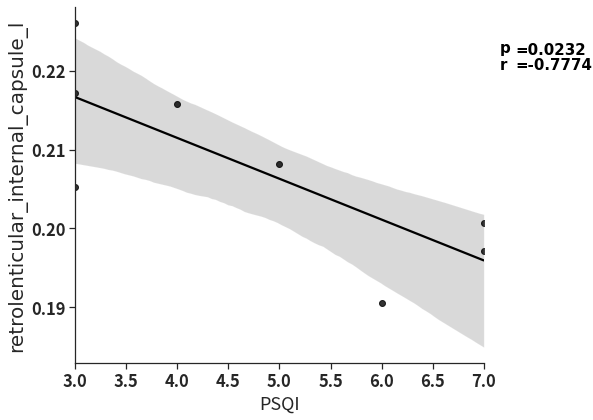

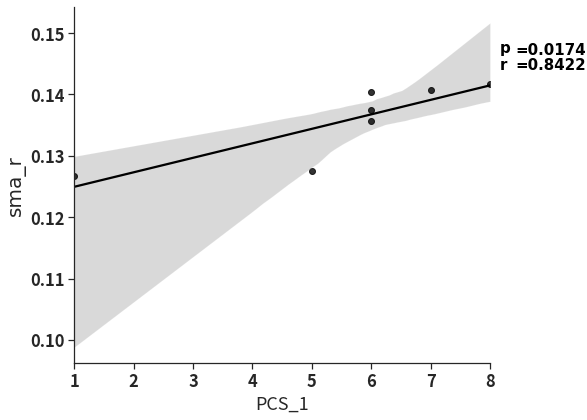

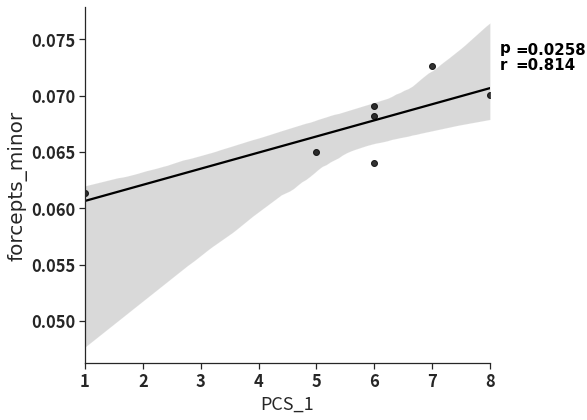

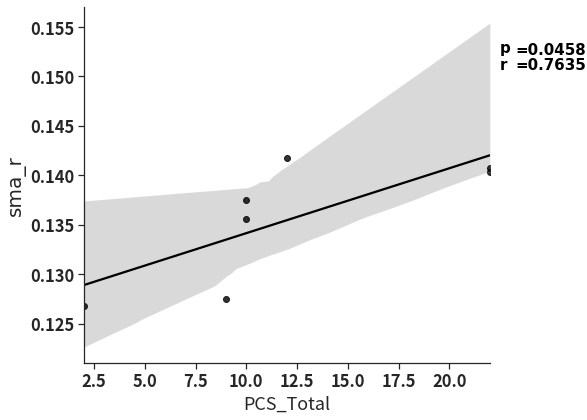

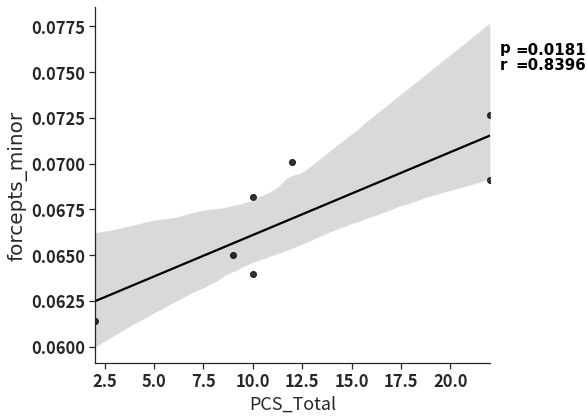

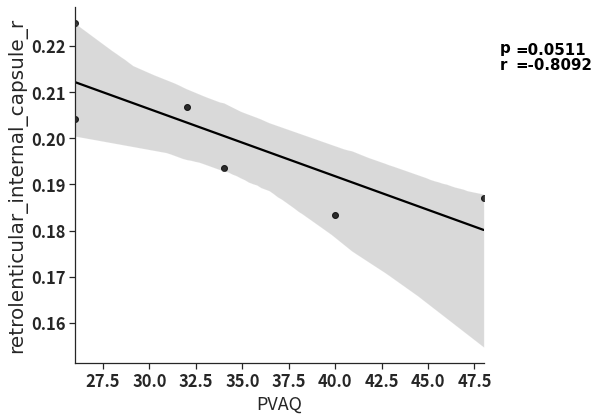

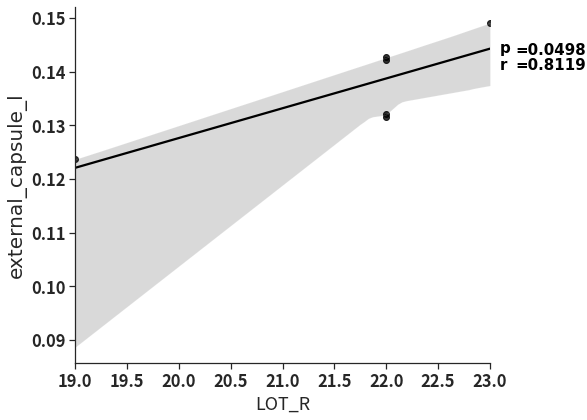

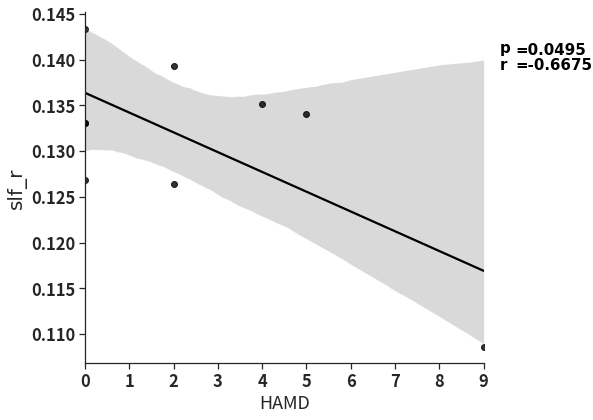

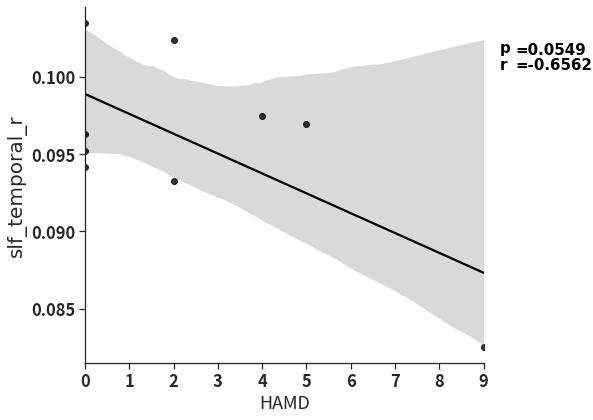

p value of pearson correlation test:


,SFMPQ,PDQ,PSQ,BDI,TAI,PSQI,FPQ_Severe,FPQ_Mild,FPQ_Medical,FPQ_Total,PASS,PCS_1,PCS_2,PCS_3,PCS_Total,PVAQ,LOT_R,SAI,VAS,HAMA,HAMD
corticospinal_l,0.8656,0.4405,0.8710,0.2531,0.9271,0.1124,0.6734,0.9359,0.8978,0.8660,0.8192,0.2510,0.7167,0.6952,0.6215,0.2396,0.0619,0.2494,0.9396,0.3118,0.2936
external_capsule_l,0.9347,0.2045,0.9189,0.2726,0.7744,0.7179,0.3859,0.6515,0.8639,0.6532,0.6876,0.2204,0.5492,0.3772,0.2539,0.7189,0.0498,0.1423,0.9677,0.5184,0.5874
retrolenticular_internal_capsule_l,0.9150,0.3469,0.8529,0.2708,0.6081,0.0232,0.9885,0.9320,0.8730,0.9820,0.5958,0.3435,0.4035,0.8399,0.8464,0.1986,0.0869,0.4053,0.7426,0.2599,0.2388
retrolenticular_internal_capsule_r,0.8145,0.8564,0.6609,0.2027,0.6928,0.1768,0.4140,0.7273,0.7440,0.5680,0.4167,0.6335,0.2679,0.9581,0.8657,0.0511,0.1087,0.1357,0.5535,0.2186,0.1599
sma_r,0.5827,0.3857,0.7212,0.4249,0.2404,0.6148,0.7394,0.3349,0.2752,0.4404,0.1870,0.0174,0.1963,0.2115,0.0458,0.6007,0.8152,0.6107,0.3297,0.5379,0.3834
slf_l,0.6943,0.2600,0.7161,0.2166,0.7219,0.0860,0.9509,0.6512,0.4888,0.7036,0.8265,0.1305,0.9156,0.3909,0.3295,0.3929,0.1234,0.4059,0.9112,0.3062,0.1970
slf_r,0.8228,0.5116,0.7779,0.0625,0.7061,0.4642,0.4382,0.9562,0.8465,0.7709,0.9301,0.3347,0.9388,0.4911,0.4693,0.3441,0.1306,0.1770,0.6871,0.1139,0.0495
slf_temporal_l,0.7188,0.3154,0.8125,0.2037,0.7224,0.1468,0.8559,0.7246,0.5755,0.8417,0.9267,0.1996,0.7975,0.4751,0.4387,0.2910,0.1343,0.3133,0.9525,0.3381,0.2112
slf_temporal_r,0.9884,0.3893,0.8362,0.0769,0.6765,0.2597,0.6845,0.7699,0.5839,0.9370,0.9691,0.2672,0.6619,0.4479,0.4802,0.2385,0.1817,0.1972,0.7753,0.1651,0.0549
corticospinal_r,0.9692,0.3933,0.8517,0.1052,0.9789,0.1229,0.7852,0.9786,0.8110,0.9594,0.9927,0.1393,0.9643,0.6428,0.4595,0.4342,0.0692,0.3222,0.9203,0.1328,0.1252


In [16]:
dti_list = patient_tbss.columns
scale_list = list(scale_pt.columns[1:])
del scale_list[-9:-4]
rows = len(dti_list)
cols = len(scale_list)
# Patients' correlation matrix
tbss_coefficient_matrix = pd.DataFrame(np.zeros(rows*cols).reshape(rows,cols),  index=dti_list,columns=scale_list)
tbss_p_matrix = pd.DataFrame(np.zeros(rows*cols).reshape(rows,cols), index=dti_list,columns=scale_list)
tbss_p_matrix_perm = tbss_p_matrix.copy()
tbss_norm_matrix = tbss_p_matrix.copy()


for scale in scale_list:
    x_label = scale
    for y_label in dti_list:

        df = corr[[x_label, y_label]]
        df = df.dropna(how='any',axis=0) # drop any row with missing value to prevent overfit

        norm_bool = 1 if multivariate_normality(df[[x_label, y_label]])[2] else 0
        tbss_norm_matrix.loc[y_label, x_label] = norm_bool

        pccs = stats.pearsonr(df[x_label], df[y_label])
        tbss_coefficient_matrix.loc[y_label, x_label] = round(pccs[0],4)
        tbss_p_matrix.loc[y_label, x_label] = round(pccs[1],4)

        if pccs[1] < 0.06:

            plt.figure(figsize=(8,6))
            '''decorate image'''
            sns.set(font_scale=1.5)
            sns.set_style("white")
            plt.rcParams["font.weight"] = "bold"
            plt.rcParams["font.family"] = 'Noto Sans CJK JP'

            ax = plt.gca()      #gca='get current axis'
            # 将右边和上边的边框（脊）的颜色去掉
            ax.spines['right'].set_color('none')
            ax.spines['top'].set_color('none')

            # 绑定x轴和y轴
            font2 = {'weight' : 'normal','size'   : 20, }
            
            ax.xaxis.set_ticks_position('bottom')
            ax.yaxis.set_ticks_position('left')
            sns.set(color_codes=True)

            sns.regplot(x=x_label, y=y_label, data=df,color='black')
            plt.ylabel('{}'.format(y_label),font=font2)
            plt.annotate("p\nr", xy=(500, 350), xycoords='figure points',fontsize=15,color="black")

            plt.annotate("={}".format(round(tbss_p_matrix.loc[y_label, x_label],4)), 
            xy=(515, 365), xycoords='figure points',fontsize=15,color="black")
            plt.annotate("={}".format(tbss_coefficient_matrix.loc[y_label, x_label]), 
            xy=(515, 350), xycoords='figure points',fontsize=15,color="black")
            plt.tight_layout()
            plt.savefig('chart/tbss_{}_{}一元线性回归.svg'.format(x_label, y_label))
            plt.show()
print("p value of pearson correlation test:")
tbss_p_matrix

<AxesSubplot:>

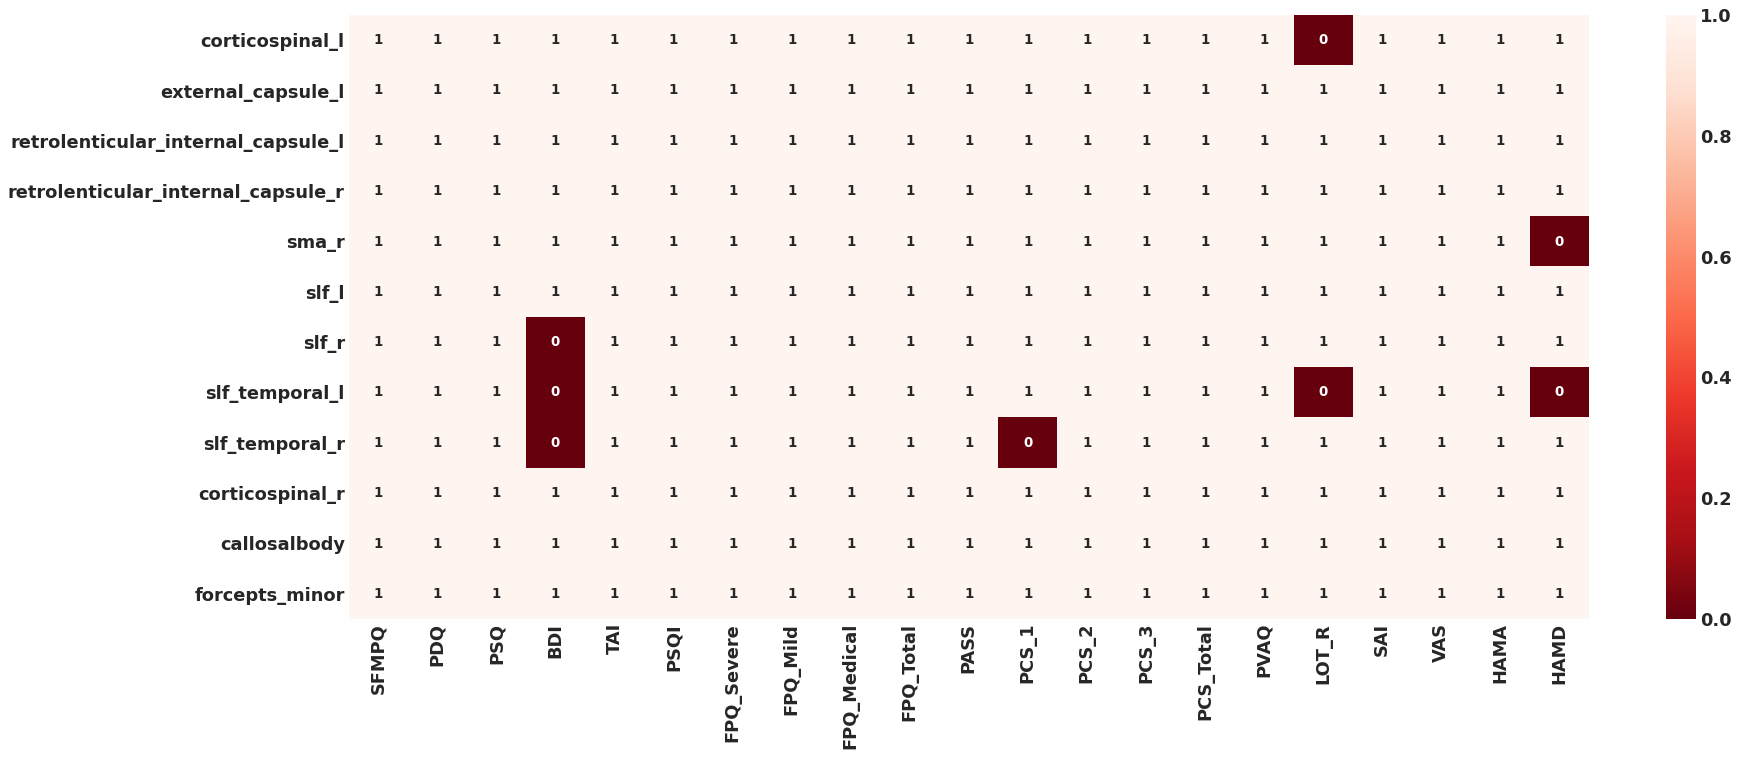

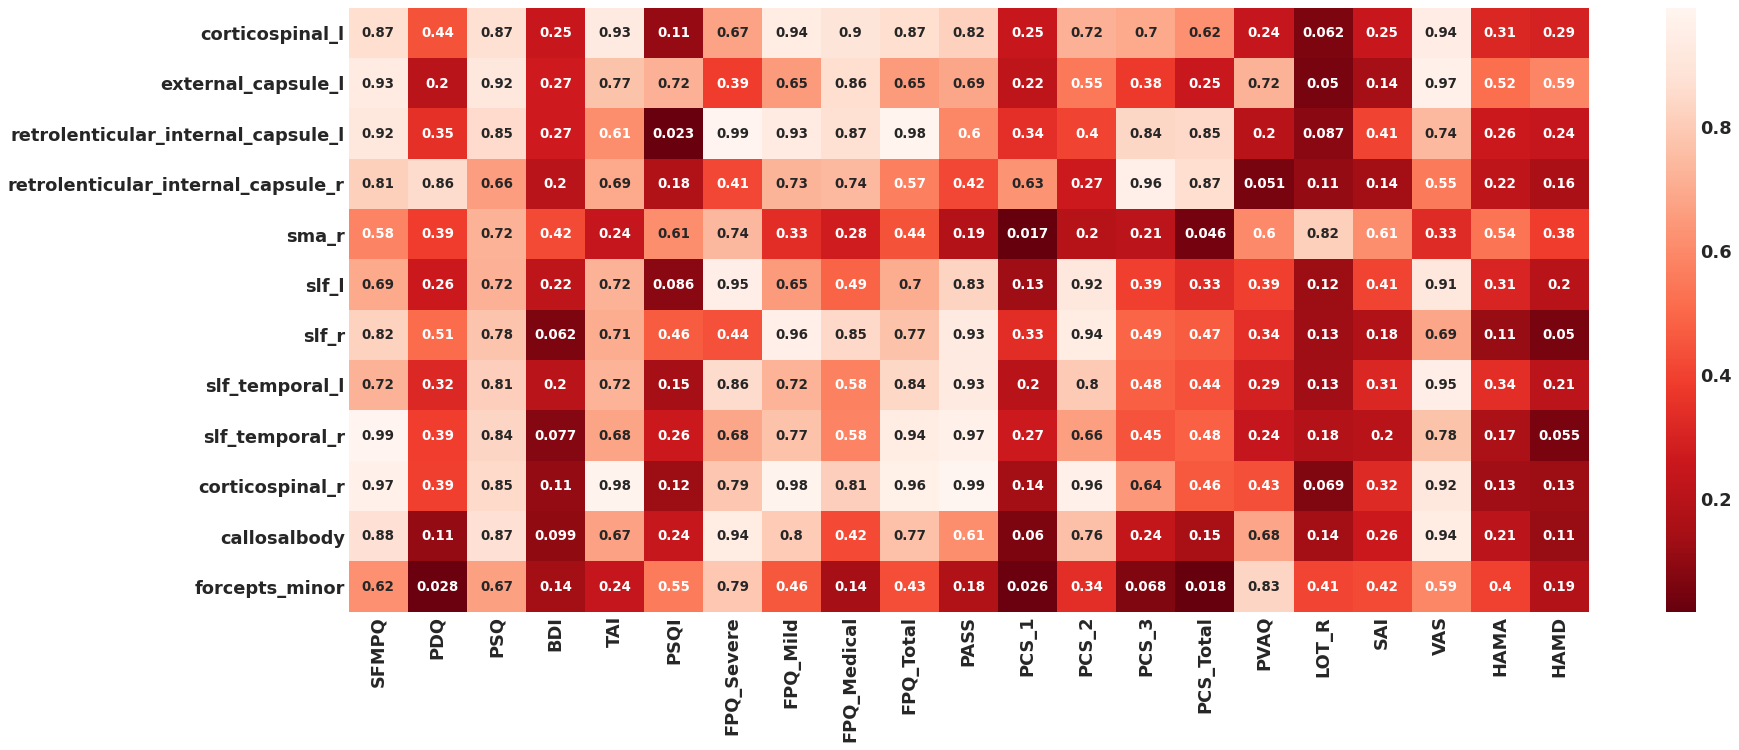

In [17]:
large = 22; med = 16; small = 12
params = {'axes.titlesize': large, 'legend.fontsize': med,  'figure.figsize': (16, 10), 'axes.labelsize': med,
          'axes.titlesize': med,   'xtick.labelsize': med,  'ytick.labelsize': med,  'figure.titlesize': large}

plt.figure(figsize=(25,10), dpi= 80)

plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
plt.rcParams['axes.unicode_minus'] = False  
sns.heatmap(tbss_norm_matrix, cmap='Reds_r', annot=True)

plt.figure(figsize=(25,10), dpi= 80)

plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
plt.rcParams['axes.unicode_minus'] = False  

sns.heatmap(tbss_p_matrix, cmap='Reds_r', annot=True)


## Comparasion (Pt1 & Pt2)
9 subjcets. sub-p13, sub-p14 do not have dti b0 image, use first volumn of dti data to create mask for eddy correction, change the file name for consistency.

In [18]:
tbss_result = []
for region in tbss_data.columns[:-1]:
    lev = stats.levene(patient_tbss[region], patient_tbss_2[region])
    equal_var = True if lev[1]>0.05 else False
    t_result = stats.ttest_ind(patient_tbss[region], patient_tbss_2[region], equal_var=equal_var)
    tbss_result.append(stats.shapiro(patient_tbss[region])+stats.shapiro(patient_tbss_2[region])+lev+tuple([round(t_result[0],5),round(t_result[1],5)]))
tbss_result_df = pd.DataFrame(tbss_result, index=tbss_data.columns[:-1], columns=['hc_norm_stat','hc_norm_p', 'pt_norm_stat','pt_norm_p','levene_stat', 'levene_p','ind_t','ind_t_p'])

In [19]:
tbss_result_df

,hc_norm_stat,hc_norm_p,pt_norm_stat,pt_norm_p,levene_stat,levene_p,ind_t,ind_t_p
corticospinal_l,0.961205,0.799518,0.923109,0.418598,0.057271,0.813723,-1.32996,0.20110
external_capsule_l,0.970590,0.896258,0.904381,0.278500,0.166830,0.688043,-0.86021,0.40164
retrolenticular_internal_capsule_l,0.951780,0.689587,0.922135,0.410210,0.116357,0.737200,-0.96666,0.34727
retrolenticular_internal_capsule_r,0.987747,0.993244,0.983926,0.981394,0.013786,0.907909,-0.64434,0.52796
sma_r,0.881399,0.135404,0.878125,0.150034,0.068937,0.796046,2.00200,0.06150
slf_l,0.946917,0.632197,0.903668,0.274034,0.293534,0.594995,0.14498,0.88644
slf_r,0.869816,0.099473,0.800932,0.020928,0.082536,0.777362,0.33831,0.73927
slf_temporal_l,0.949073,0.657545,0.878446,0.151210,0.378354,0.546632,-1.07897,0.29567
slf_temporal_r,0.890241,0.170638,0.881686,0.163554,0.000732,0.978735,-0.82197,0.42247
corticospinal_r,0.954033,0.716284,0.925929,0.443573,0.170036,0.685233,1.27612,0.21907


In [20]:
tbss_data.groupby('timepoint').mean().T

timepoint,0,1,2
corticospinal_l,0.123134,0.119792,0.122874
external_capsule_l,0.142659,0.136539,0.139540
retrolenticular_internal_capsule_l,0.217580,0.207104,0.212609
retrolenticular_internal_capsule_r,0.209498,0.198639,0.203099
sma_r,0.142115,0.135653,0.129080
slf_l,0.067000,0.064708,0.064450
slf_r,0.139188,0.132219,0.130699
slf_temporal_l,0.091304,0.087894,0.090665
slf_temporal_r,0.101027,0.096249,0.098501
corticospinal_r,0.124888,0.120790,0.117597


均值上是有回升趋势的，但是统计上并不显著。
有边缘显著差异的 supplementary motor area 是显著下降

# Create Table

In [21]:
patient_tbss.describe()

,corticospinal_l,external_capsule_l,retrolenticular_internal_capsule_l,retrolenticular_internal_capsule_r,sma_r,slf_l,slf_r,slf_temporal_l,slf_temporal_r,corticospinal_r,callosalbody,forcepts_minor
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.119792,0.136539,0.207104,0.198639,0.135653,0.064708,0.132219,0.087894,0.096249,0.120790,0.095874,0.066516
std,0.005137,0.007730,0.012119,0.015147,0.007272,0.003894,0.010091,0.005587,0.005920,0.005752,0.005553,0.004502
min,0.112235,0.123661,0.190483,0.172373,0.123061,0.057314,0.108541,0.077678,0.082501,0.108904,0.086477,0.059366
25%,0.117700,0.131700,0.198057,0.188720,0.129553,0.062723,0.128389,0.085318,0.094446,0.118388,0.091670,0.063715
50%,0.119571,0.136912,0.206742,0.201253,0.138335,0.064860,0.133592,0.087550,0.096640,0.121402,0.096334,0.066593
75%,0.123265,0.142071,0.216802,0.206190,0.140629,0.068019,0.138266,0.092544,0.099909,0.124414,0.100688,0.069826
max,0.128892,0.149049,0.226077,0.224986,0.144122,0.069529,0.143346,0.095045,0.103501,0.129055,0.103047,0.072667


In [22]:
control_tbss.describe()

,corticospinal_l,external_capsule_l,retrolenticular_internal_capsule_l,retrolenticular_internal_capsule_r,sma_r,slf_l,slf_r,slf_temporal_l,slf_temporal_r,corticospinal_r,callosalbody,forcepts_minor
count,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000
mean,0.123134,0.142659,0.217580,0.209498,0.142115,0.067000,0.139188,0.091304,0.101027,0.124888,0.099356,0.069009
std,0.005218,0.007338,0.012312,0.011998,0.007619,0.004392,0.011757,0.005700,0.007043,0.005750,0.003665,0.002810
min,0.115537,0.129719,0.197761,0.188610,0.130217,0.061413,0.122654,0.083654,0.090409,0.117743,0.094477,0.063096
25%,0.120361,0.137619,0.209153,0.200927,0.136477,0.063750,0.133144,0.087154,0.096288,0.121103,0.096439,0.067710
50%,0.121717,0.143160,0.218081,0.207669,0.142047,0.066841,0.137572,0.090902,0.099929,0.124433,0.099747,0.068732
75%,0.124906,0.145652,0.222841,0.218480,0.145996,0.068603,0.141821,0.093192,0.104473,0.127079,0.100466,0.070358
max,0.137732,0.157466,0.243773,0.235660,0.161623,0.080478,0.175616,0.108483,0.120270,0.141441,0.108497,0.075359


In [28]:
rows = len(patient_tbss.columns)
data_df = pd.DataFrame(np.zeros(rows *2).reshape(rows, 2), index=patient_tbss.columns, columns = [['Patient', 'Control'],
                                                                                                    ['Mean ± SD', 'Mean ± SD']])
for df_index, df in enumerate([patient_tbss, control_tbss]):
    col_index = 'Patient' if df_index==0 else 'Control'
    for region in control_tbss.columns:
        string = "{} ± {}".format(round(df.describe().loc['mean',region]*100,2), round(df.describe().loc['std', region]*100,2))
        data_df.loc[region, col_index] = string
data_df

,Patient,Control
,Mean ± SD,Mean ± SD
corticospinal_l,11.98 ± 0.51,12.31 ± 0.52
external_capsule_l,13.65 ± 0.77,14.27 ± 0.73
retrolenticular_internal_capsule_l,20.71 ± 1.21,21.76 ± 1.23
retrolenticular_internal_capsule_r,19.86 ± 1.51,20.95 ± 1.2
sma_r,13.57 ± 0.73,14.21 ± 0.76
slf_l,6.47 ± 0.39,6.7 ± 0.44
slf_r,13.22 ± 1.01,13.92 ± 1.18
slf_temporal_l,8.79 ± 0.56,9.13 ± 0.57
slf_temporal_r,9.62 ± 0.59,10.1 ± 0.7


In [1]:
!fsleyes -std ../TBSS_pt12/tbss/stats/mean_FA_skeleton -cm green  \
../TBSS_pt12/tbss/stats/tbss_tfce_corrp_tstat1 -cm red-yellow -dr 0.949 1

In [ ]:
!fsleyes -std ../TBSS_pt12/tbss/stats/mean_FA_skeleton -cm green  \
../TBSS_pt12/tbss/stats/tbss_tfce_corrp_tstat2 -cm red-yellow -dr 0.949 1